In [1]:
#import sys
#!{sys.executable} -m pip install hitran-api 

import json
import numpy as np
import matplotlib.pyplot as plt

### Setup Instructions

If you unzip the `greenhouse-absorptions.json`, you should be able to run almost everything in this notebook (just comment out any calls to the HAPI library unless you have it installed already) using precomputed molecular cross sections for specific temperatures at $P = 1$ atm. You can use this to quickly play around with the curve fitting without redownloading or recomputing anything from HITRAN (which is pretty slow).

If you want to dive into the spectroscopic data, you can install HAPI (the HITRAN API) in your Jupyter environment by uncommenting the line at the very top. This will allow you to connect to the HITRAN database and pull any available data under any pressure-temperature conditions, and (with a few tweaks) generalize this code to model the opacity of a mixture (by summing their individual $\kappa(\nu)$ values into a total cross section).

The HITRAN sections are disabled by default, so you shouldn't need to install HAPI if `use_HITRAN = False` (it will just use the data from `greenhouse-absorptions.json`).

In [2]:
use_HITRAN = False

if use_HITRAN: 
    from hapi import *

### 1. Idealized Greenhouse with Temperature-Dependent Opacity

This implements a simple greenhouse model for a one-layer atmosphere subject to the Beer-Lambert law, which states that the flux transmitted is an exponentially decaying function of the incoming flux and the optical thickness $\tau$
$$ F(\nu, \tau) = F(\nu,0) e^{-\tau(\nu)} $$

Since calculating dynamic line-by-line opacities is a computationally expensive process, we can compute band-averaged absorption factors (see section 3 for details) which defines the total fraction absorbed from a given blackbody emission spectrum 
$$ \tilde{\tau}(T) = \frac{ \int \ [1 - e^{-\tau(\nu, T)}] \cdot B(\nu, T_{surf})  \ d \nu}{\int \ B(\nu, T_{surf}) \ d \nu}$$

And then solves a $2 \times 2$ matrix-vector equation to obtain the surface and atmospheric temperatures that would satisfy a simple radiative balance. This could be generalized to include more layers and more realistic physics, this is just a quick example to demonstrate how to run this to convergence with temperature-dependent opacities (so we only consider opacity-dependent absorption and blackbody emission, and we neglect reflection, scattering, emissivity, etc). 

T(100 ppm CO2) = [179.29310765 274.42561172] 		Fluxes = [ 58.5957498 321.5957498]
[[2, -0.12186572620336948], [-1, 1]] [78.0, 263.0]
T(200 ppm CO2) = [180.8396061  274.86147149] 		Fluxes = [ 60.64373568 323.64373568]
[[2, -0.13375037608162155], [-1, 1]] [78.0, 263.0]
T(400 ppm CO2) = [182.16882238 275.24342882] 		Fluxes = [ 62.44647671 325.44647671]
[[2, -0.14408806599324162], [-1, 1]] [78.0, 263.0]
T(800 ppm CO2) = [183.36318741 275.59244948] 		Fluxes = [ 64.10034035 327.10034035]
[[2, -0.15347180819628478], [-1, 1]] [78.0, 263.0]
T(1600 ppm CO2) = [184.43870404 275.91146864] 		Fluxes = [ 65.61754603 328.61754603]
[[2, -0.16199710788981825], [-1, 1]] [78.0, 263.0]
T(3200 ppm CO2) = [185.40899955 276.20313608] 		Fluxes = [ 67.00928417 330.00928417]
[[2, -0.1697484617058445], [-1, 1]] [78.0, 263.0]
T(6400 ppm CO2) = [186.28577567 276.46985001] 		Fluxes = [ 68.28581775 331.28581775]
[[2, -0.17680091435554635], [-1, 1]] [78.0, 263.0]


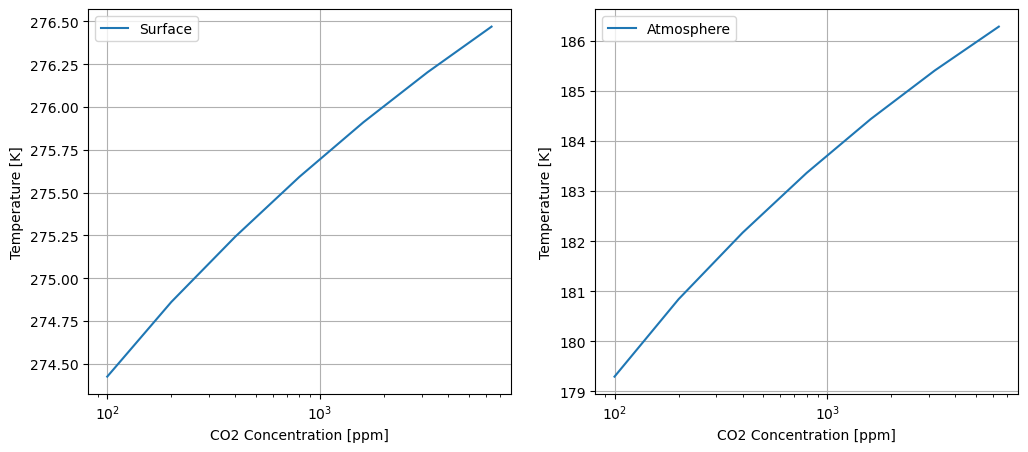

In [3]:
def opacity_fit(ln_ppm, ln_T, params): 
    return params[0] * (1 - np.exp(-params[1] * (ln_ppm + params[2] + (params[3] * ln_T**params[4])))) 


fit_params = [  0.2506888,   0.12752484, -62.59440735,  32.08590306,   0.41178164]
concentrations = [ 100, 200, 400, 800, 1600, 3200, 6400 ]
temperatures = list(range(50, 1001, 50))


sb = 5.670374419e-8        # The Stefan-Boltzmann constant (F = sb * T^4)
F_in = 341.                # Incoming stellar flux
opacity_sw = 78./341.      # Total fraction of stellar flux absorbed by atmosphere



fig, axes = plt.subplots(1,2,figsize=(12,5))
T_init = np.asarray([ 200, 300 ])
T_surf, T_atm, = [], []

for CO2_ppm in concentrations:
    T = T_init.copy()
    T_prev = np.asarray([0,0])
    while np.max(np.abs(T - T_prev)) > 1:
        opacity_lw = opacity_fit(np.log(CO2_ppm), np.log(T[0]), fit_params)
        b = [ F_in * opacity_sw,   F_in * (1-opacity_sw) ]
        M = [ [2, -opacity_lw], [-1, 1] ]        
        F = np.linalg.solve(M, b)
        T_prev = T.copy()
        T = (F / sb)**0.25
    T_atm.append( T[0] )
    T_surf.append( T[1] )
    print( "T(" + str(CO2_ppm), "ppm CO2) =", T , "\t\tFluxes =", F )
    print( M, b)


axes[0].plot(concentrations, T_surf, label="Surface")
axes[1].plot(concentrations, T_atm, label="Atmosphere")


for ax in axes:
    ax.set_xlabel("CO2 Concentration [ppm]")
    ax.set_ylabel("Temperature [K]")
    ax.legend()
    ax.grid()
    ax.set_xscale("log")

### 2. Molecular Cross-Sections from HITRAN Data

This section downloads data from the HITRAN database (or just reads the file of precomputed results) and plots the data for demonstration. If you want to download new data, this is where you'd make your changes, but otherwise you just need to run them to make sure all the functions and data structures are defined.

In [4]:

# Wavenumber range in cm^-1
nu_min = 600
nu_max = 1500  
P_s = 1.013e5         # Surface pressure in Pascals

greenhouse_gases = { "CO2": { "id": 2, "iso": 1, "ppm": 400 }, 
                     "CH4": { "id": 6, "iso": 1, "ppm": 2 } }

# Download data for from the HITRAN database (if needed)
if use_HITRAN:
    print( "[main] Fetching from the HITRAN database" ) 
    db_begin('data')
    for name, attr in greenhouse_gases.items():
        print( "[main]", name, attr )
        fetch(name, attr['id'], attr['iso'], nu_min, nu_max)
        print( "[main] Done with", name)

In [5]:


def blackbody_spectrum(nu, T, h = 6.626e-34, c = 3.0e10, kb = 1.381e-23):
    """
    Computes the blackbody emission spectrum for a body at temperature T
        - nu: The wavenumber range of the spectrum in units of [cm^-1]
        - T: The temperature of the body [Kelvin]
    Default: Planck constant h [Joule-second], Speed of light c [cm/s], Boltzmann constant kb [Joule/K]
    """
    u = h * c * nu / (kb * T)   # Converts cm^-1 into the dimensionless variable u 
    return (u**3) / (np.exp(u) - 1)

    

def get_column_density(ppm, P_s, T, kb = 1.381e-23, N_A = 6.022e23):
    """
    Converts a concentration in ppm to a column density [molecules/m^2]
    - ppm: The concentration of the target gas molecule [parts per million]
    - P_s: The surface pressure [atm]
    Default: Boltzmann constant kb [Joule/K], Avogadro's number N_A [Joule-second]
    """
    mole_fraction = ppm / 1e6       # Convert ppm to fraction
    return mole_fraction * P_s / (kb*T)



T_sun = 5770
T_surf = 288.15   # Earth's "average" surface temperature in Kelvin


global_attr = { "nu": [1, 2500] }
try:
    if use_HITRAN:
        print( "Already computed", len(absorptions), "temperatures, adding any missing ones now" )
    else:
        print( "Already computed", len(absorptions), "temperatures, proceeding to analysis" )
except:
    try:
        with open("greenhouse-absorptions.json", "r") as f:
            absorptions = json.loads( f.read() )
        absorptions = { int(T): data for T, data in absorptions.items() }
        if use_HITRAN:
            print( "Loaded", len(absorptions), "precomputed spectra, adding any missing ones now" )
        else:
            print( "Loaded", len(absorptions), "precomputed spectra, proceeding to analysis" )
    except:
        if use_HITRAN:
            print( "No precomputed results found, regenerating all spectra" )
        else:
            print( "Unable to load 'greenhouse-absorptions.json', check the file or enable HITRAN to run the fitting")



if use_HITRAN:
    # Recomputes cross sections of each gas at each temperature using the HITRAN API
    for T in temperatures:    
        print("STARTING T =", T, "K\t", end="" )
        if T not in absorptions:
            absorptions[T] = {}
        for name, attr in greenhouse_gases.items():
            if T in absorptions and name in absorptions[T]:
                print( "[Skipped "+name+"] ", end="" )
                continue
            nu_min, nu_max = global_attr["nu"]
            nu, coef = absorptionCoefficient_Voigt(SourceTables=name, Environment={'T': T, 'p': P_s / 1.013e5},
                                                    WavenumberRange=[nu_min, nu_max], GammaL='gamma_self')
            absorptions[T][name] = [ nu.tolist(), coef.tolist() ]
            print( "[Computed "+name+"] ", end="" )
        print("")
    
    with open("greenhouse-absorptions.json", "w+") as f:
        f.write( json.dumps(absorptions) )

Loaded 20 precomputed spectra, proceeding to analysis


Text(0, 0.5, 'Blackbody Emission [W/m^2]')

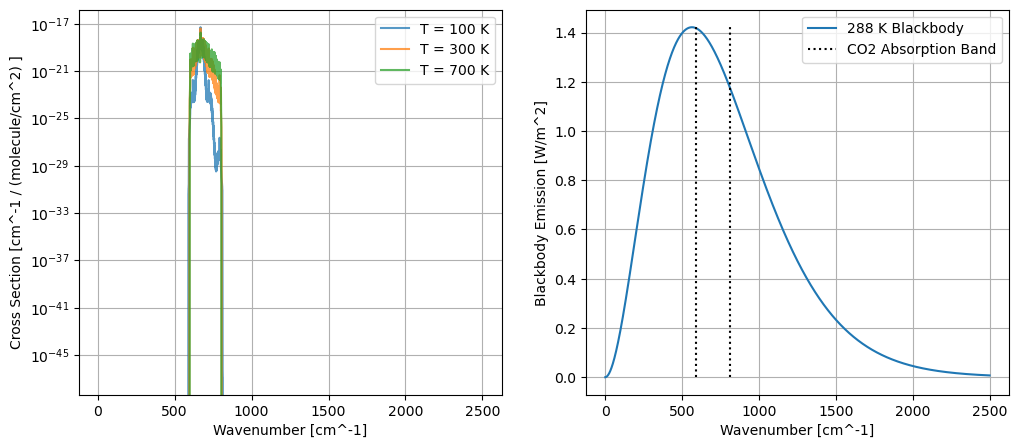

In [6]:

def blackbody_spectrum(nu, T, h = 6.626e-34, c = 3.0e10, kb = 1.381e-23):
    """
    Computes the blackbody emission spectrum for a body at temperature T
        - nu: The wavenumber range of the spectrum in units of [cm^-1]
        - T: The temperature of the body [Kelvin]
    Default: Planck constant h [Joule-second], Speed of light c [cm/s], Boltzmann constant kb [Joule/K]
    """
    u = h * c * nu / (kb * T)   # Converts cm^-1 into the dimensionless variable u 
    return (u**3) / (np.exp(u) - 1)

    

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
absorption_lines = set()
for T in [100, 300, 700]:
    nu, coef = absorptions[T]["CO2"]
    axes[0].plot(nu, coef, label = "T = " + str(T) + " K", alpha=0.75 )
    absorption_lines.update(np.nonzero( np.asarray(coef) > 1e-33 )[0].tolist())


absorption_band = [ nu[min(absorption_lines)], nu[max(absorption_lines)] ]
B = np.asarray(blackbody_spectrum(np.asarray(nu), 288.))
axes[1].plot(nu, B, label="288 K Blackbody")
axes[1].plot([absorption_band[0], absorption_band[0]], [0, np.max(B)], c="black", ls=":", label="CO2 Absorption Band")
axes[1].plot([absorption_band[1], absorption_band[1]], [0, np.max(B)], c="black", ls=":")



for ax in axes:
    ax.grid()
    ax.legend()
    ax.set_xlabel("Wavenumber [cm^-1]")

axes[0].set_ylabel("Cross Section [cm^-1 / (molecule/cm^2) ]")
axes[0].set_yscale("log")
axes[1].set_ylabel("Blackbody Emission [W/m^2]")


The basic HITRAN data provides line-by-line molecular cross sections $\kappa(\nu,T)$ (the effective "area" per molecule per unit area, reflecting the probability that a ray hits a particle and gets absorbed). To transform this to a total optical thickness, we need to integrate over particle density for a vertical column.

$$\tau(\nu, T) = \int \kappa(\nu, T) \cdot \rho(z) dz = \kappa(\nu,T) \cdot \frac{ X_{gas} \cdot P_s } {k_B \cdot T} $$

If we assume constant $\kappa(\nu)$ in the single-layer atmosphere, this is equivalent to multiplying by the column density $\rho_{col}$ (number of particles per unit area of an entire vertical column in this layer) which is a function of the mole fraction $X_{gas}$ and the surface pressure

$$\tau(\nu, T) \approx \kappa(\nu,T) \cdot \frac{ X_{gas} \cdot P_s } {k_B \cdot T} $$

In a proper treatment of a multi-layer atmosphere, both $\kappa$ and $\tau$ should vary with altitude due to changing pressure, temperature, and local mass fraction (which all contribute to the overall absorption at any specific location) but this simplification is appropriate for an idealized single-layer greenhouse atmosphere.

The plots below show the raw HITRAN data along with a blackbody emission spectrum at $T = 300 \ K$ (with the primary CO2 absorption band overlaid) 

### 3. Spectrum-Averaged Absorption from Opacity

The HITRAN data gives us pressure-broaded spectra to compute line-by-line transmission/absorption from the Beer-Lambert law, which states that the flux transmitted is an exponentially decaying function of the incoming flux and the optical thickness $\tau$
$$ F(\nu, \tau) = F(\nu,0) e^{-\tau(\nu)} $$

Which implies, through conservation of energy, that the energy absorbed by a single-layer idealized greenhouse atmosphere equals
$$ F_{abs}(\nu, \tau) = F(\nu,0) \left[ 1 - e^{-\tau(\nu)} \right ]   $$


We can use this to compute a band-averaged total absorption $\tilde{\tau}$ by integrating over the thermal emission spectrum and normalizing by the total flux emitted (effectively giving us a fractional absorption factor)
$$ \tilde{\tau}(T) = \frac{ \int \ [1 - e^{-\tau(\nu, T)}] \cdot B(\nu, T_{surf})  \ d \nu}{\int \ B(\nu, T_{surf}) \ d \nu}$$

Which lets us express the total flux absorbed and transmitted using a simpler albedo-like term that still retains the effects of absorption bands and temperature broadening (and could be generalized to model $\tilde{\tau}(T,p)$ if we include pressure as a variable). This could be extended to a multi-layer atmosphere by computing $\tilde{\tau}$ for each column fraction (corresponding to each layer's individual optical thickness) 
$$ F_{absorbed} = \tilde{\tau}(T) \cdot F_{in} \qquad \text{and} \qquad F_{transmitted} = [1-\tilde{\tau}(T)] \cdot F_{in} $$


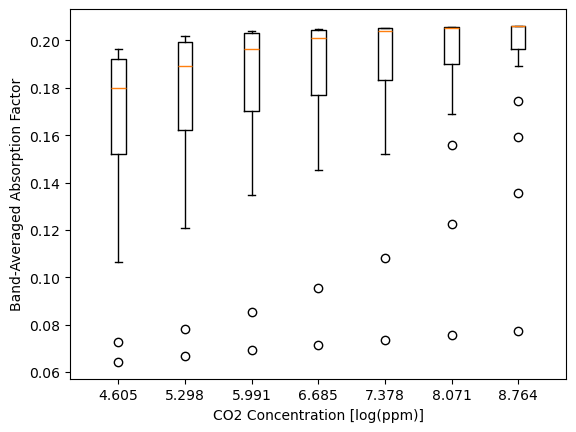

Concentrations in ppm: [100, 200, 400, 800, 1600, 3200, 6400]


In [7]:


def get_column_density(ppm, P_s, T, kb = 1.381e-23, N_A = 6.022e23):
    """
    Converts a concentration in ppm to a column density [molecules/m^2]
    - ppm: The concentration of the target gas molecule [parts per million]
    - P_s: The surface pressure [atm]
    Default: Boltzmann constant kb [Joule/K], Avogadro's number N_A [Joule-second]
    """
    mole_fraction = ppm / 1e6       # Convert ppm to fraction
    return mole_fraction * P_s / (kb*T)


opacities = {}
for ppm in concentrations:
    opacities[ppm] = []
    for T in temperatures:
        cross_section = None
        for name, attr in greenhouse_gases.items():
            if name != "CO2": continue
            column_density = get_column_density(ppm, P_s, T)
            if cross_section is None:
                cross_section = column_density * np.asarray(absorptions[T][name][1])
            else:
                continue
                cross_section += column_density * np.asarray(absorptions[T][name][1])
        nu = np.asarray(absorptions[T]["CO2"][0])
        B = blackbody_spectrum(nu, T_surf) / 100*2                  #  Converts W/m^2 to W/cm^2 to match HITRAN units
        tau = np.trapz( (1-np.exp(-cross_section)) * B, nu) / np.trapz(B, nu)
        opacities[ppm].append( tau )
    #print( ppm, "ppm:", np.round(opacities[ppm], decimals=3) )
    plt.boxplot( opacities[ppm], positions=[ np.round(np.log(ppm), decimals=3)] )


plt.gca().set_xlabel( "CO2 Concentration [log(ppm)]" )
plt.gca().set_ylabel( "Band-Averaged Absorption Factor" )
plt.show()

print("Concentrations in ppm:", concentrations)

For all concentrations, we can see the total absorption increase with temperature, but at higher concentrations we see a smaller range of values since they are approaching the saturation absorption of approximately 0.21 (indicating the total fraction of Earth's surface flux that is absorbed by CO2)
NOTE: box plots don't support log scales so I needed to transform the x data directly to display them in a readable way, the corresponding values in ppm are printed below the figure.

The band-averaged absorption factor can be approximated by an upside-down exponential decay in the form
$$ \tilde{\tau}(X_{gas}, T) = a_0 \left[ 1 - e^{-f(X_{gas}, T)} \right] $$

Where the polynomial $f(X_{gas}, T)$ is a function of the **natural logarithm** of concentration (in ppm) and temperature (in Kelvin)
$$ f(X_{gas}, T) = a_1 \left[ \text{ln}(X_{gas}) + a_2 \cdot \text{ln}(T)^{a_3} + a_4 \right] $$



Best fit for 200 - 1000 K (maximum error of ~5% in the habitable zone) <br>
`a = [   0.21621827    0.24420695 -119.03910349   82.5081991     0.21416547]`
 

Initial best fit shared on Tuesday (range of 200 - ??? K, which reduced error to within ~2% this in region) <br>
`a = [  0.2506888    0.12752484 -62.59440735  32.08590306   0.41178164]`


Best fit for 150-450 K (should match the fit you see below, if you use default parameters) <br>
`a = [  0.28428   0.09057 -68.41937  38.07629   0.37119]`

You can play around with the temperature range to tune the fit to minimize errors for a specific window rather than the entire data set 

In [8]:
T_range = [150, 450]                                      # Only fits the curve to this range (trades generality for accuracy)

Parameters:	 [  0.28428   0.09057 -68.41937  38.07629   0.37119]


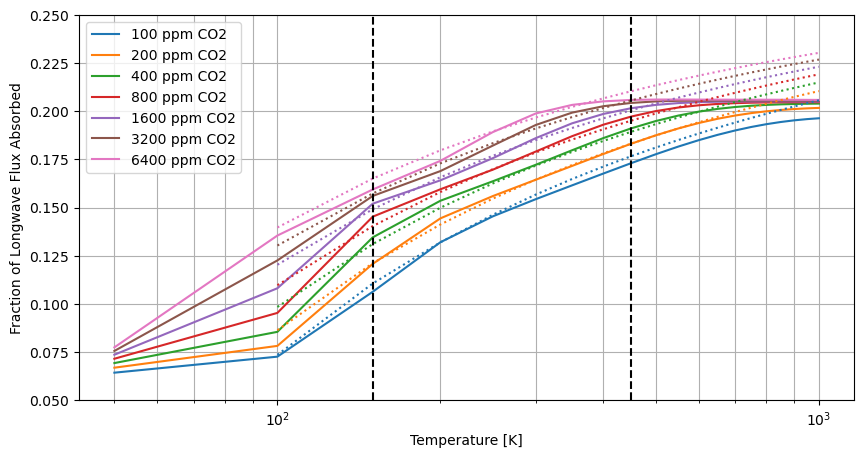

In [9]:

from scipy.optimize import minimize
np.set_printoptions(suppress=True)                        # OPTIONAL: stops numpy from printing in scientific notation


def model(x, params): 
    return opacity_fit(x[:,0], x[:,1], params)
                                

def residuals(params): 
    return np.sum((y_data - model(x_data, params))**2)



x_data0, x_data, y_data = [], [], [] 
for ppm in opacities:
    for T, opacity in zip(temperatures, opacities[ppm]):
        if T < T_range[0] or T > T_range[1]: continue
        x_data0.append( [ppm, T] )
        y_data.append( opacity )
x_data0 = np.asarray(x_data0)
x_data = np.log(x_data0)
y_data = np.asarray(y_data)

params_init = [1, 1, 0, 1, 0]                              # Initial values for L and k (required by the minimizer)
result = minimize(residuals, params_init)
print( "Parameters:\t", np.round(result.x, decimals=5) )


fig, ax = plt.subplots(figsize=(10,5))
for ppm, opacity in opacities.items():
    x_data, y_data = temperatures, np.asarray(opacity)
    ax.plot( x_data, y_data, label = str(ppm) + " ppm CO2" )
ax.set_prop_cycle(None)


for ppm in opacities:
    x_data, y_data = [], []
    subtemps = []
    for T, opacity in zip(temperatures, opacities[ppm]):
        if T < 100: continue
        x_data.append( [ppm, T] )
        y_data.append( opacity )
        subtemps.append( T )
    x_data, y_data = np.log(x_data), np.asarray(y_data)    
    plt.plot( subtemps, model(x_data,result.x), ls=":")


plt.plot( [T_range[0], T_range[0]], [0.05, 0.25], c='black', ls='--')
plt.plot( [T_range[1], T_range[1]], [0.05, 0.25], c='black', ls='--')

plt.gca().set_ylim([0.05,0.25])
plt.gca().set_xscale("log")
plt.gca().set_xlabel("Temperature [K]")
plt.gca().set_ylabel("Fraction of Longwave Flux Absorbed")
plt.gca().grid(which="both")
plt.gca().legend()